# Modèles multi vue sur un échantillon de 20%

In [2]:
from dotenv import load_dotenv, find_dotenv
import numpy as np
import datetime, os
import tarfile
import os
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical, array_to_img, img_to_array, load_img, image_dataset_from_directory
from keras import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import datetime

2023-01-10 06:58:09.854588: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-10 06:58:10.047060: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-10 06:58:10.047099: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-10 06:58:11.366291: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
load_dotenv(find_dotenv())
PATH_TO_SMALL_ROI_TYP_FOR_KERAS = os.environ.get("PATH_TO_SMALL_ROI_TYP_FOR_KERAS")
RECTO_PATH = os.path.join(PATH_TO_SMALL_ROI_TYP_FOR_KERAS,'RECTO')
VERSO_PATH = os.path.join(PATH_TO_SMALL_ROI_TYP_FOR_KERAS,'VERSO')
RECTO_PATH

'/home/ensai/Bureau/3A/PFE/data/Images_ROI/Images_ROI_Typ_for_multiview_echant/RECTO'

In [3]:
PATH_TO_SMALL_ROI_TYP_FOR_KERAS = "/home/onyxia/work/data/Images_ROI/Images_ROI_Typ_for_multiview_echant"
RECTO_PATH = os.path.join(PATH_TO_SMALL_ROI_TYP_FOR_KERAS,'RECTO')
VERSO_PATH = os.path.join(PATH_TO_SMALL_ROI_TYP_FOR_KERAS,'VERSO')

In [17]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
CHANNELS = 3
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)
BATCH_SIZE = 32
CLASSES = 8

In [ ]:
tf.random.set_seed(
    1234
)


### Importation des données

In [5]:
trainR  = image_dataset_from_directory(RECTO_PATH,
image_size=(IMG_WIDTH,IMG_HEIGHT),
batch_size=BATCH_SIZE,
validation_split=0.2,
subset='training',
seed=12345,
crop_to_aspect_ratio=True,
shuffle=True)

valR = image_dataset_from_directory(RECTO_PATH,
image_size=(IMG_WIDTH,IMG_HEIGHT),
batch_size=BATCH_SIZE,
validation_split=0.2,
subset='validation',
seed=12345,
crop_to_aspect_ratio=True,
shuffle=True)

trainV  = image_dataset_from_directory(VERSO_PATH,
image_size=(IMG_WIDTH,IMG_HEIGHT),
batch_size=BATCH_SIZE,
validation_split=0.2,
subset='training',
seed=12345,
crop_to_aspect_ratio=True,
shuffle=True)

valV = image_dataset_from_directory(VERSO_PATH,
image_size=(IMG_WIDTH,IMG_HEIGHT),
batch_size=BATCH_SIZE,
validation_split=0.2,
subset='validation',
seed=12345,
crop_to_aspect_ratio=True,
shuffle=True)


Found 2301 files belonging to 7 classes.
Using 1841 files for training.


2023-01-10 06:58:21.188010: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-10 06:58:21.188053: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-10 06:58:21.188093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2023-01-10 06:58:21.188622: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 2301 files belonging to 7 classes.
Using 460 files for validation.
Found 2301 files belonging to 7 classes.
Using 1841 files for training.
Found 2301 files belonging to 7 classes.
Using 460 files for validation.


### Traitements pour double entrée

In [6]:
X_train_R = tf.zeros(shape=(32, 224, 224, 3),dtype=tf.float32)
y_train_tensor = tf.zeros(shape=(32,),dtype=tf.int32)
for recto in trainR:
    X_train_R = tf.concat([X_train_R,recto[0]],0)
    y_train_tensor = tf.concat([y_train_tensor,recto[1]],0)

X_train_V = tf.zeros(shape=(32, 224, 224, 3),dtype=tf.float32)
for verso in trainV:
    X_train_V = tf.concat([X_train_V,verso[0]],0)

X_test_V = tf.zeros(shape=(32, 224, 224, 3),dtype=tf.float32)
for verso in valV:
    X_test_V = tf.concat([X_test_V,verso[0]],0)

X_test_R = tf.zeros(shape=(32, 224, 224, 3),dtype=tf.float32)
y_test_tensor = tf.zeros(shape=(32,),dtype=tf.int32)
for recto in valR:
    X_test_R = tf.concat([X_test_R,recto[0]],0)
    y_test_tensor = tf.concat([y_test_tensor,recto[1]],0)




### Création du modèle multi-vue basique

In [7]:
base_model = tf.keras.applications.EfficientNetB5(input_shape=INPUT_SHAPE,
include_top=False,
weights='imagenet')
model=base_model
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

115263384/115263384 [==============================] - 7s 0us/step


In [8]:
base_model2 = tf.keras.applications.VGG16(input_shape=INPUT_SHAPE,
include_top=False,
weights='imagenet')
model2=base_model2
preprocess_input2 = tf.keras.applications.vgg16.preprocess_input

58889256/58889256 [==============================] - 3s 0us/step


In [10]:
base_model.trainable = False
base_model2.trainable = False

In [17]:
inputs1 = tf.keras.Input(shape=(224, 224, 3))
x1 = preprocess_input(inputs1)
x1 = base_model(x1, training=False)
x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)
x1 = tf.keras.layers.Dropout(0.2)(x1)
inputs2 = tf.keras.Input(shape=(224, 224, 3))
x2 = preprocess_input2(inputs2) # x2 = preprocess_input(inputs2)
x2 = base_model2(x2, training=False) # x2 = base_model(x2, training=False)
x2 = tf.keras.layers.GlobalAveragePooling2D()(x2)
x2 = tf.keras.layers.Dropout(0.2)(x2)
fuz = tf.keras.layers.Concatenate()([x1, x2])
x = tf.keras.layers.Dense(1024,activation='relu')
x = tf.keras.layers.Dense(CLASSES, activation = 'softmax')(fuz)
outputs = x
model = tf.keras.Model(inputs=[inputs1,inputs2], outputs=outputs)

<bound method KerasTensor.get_shape of <KerasTensor: shape=(None, 2560) dtype=float32 (created by layer 'concatenate_1')>>


In [10]:
base_learning_rate = 10**(-3)
model.compile(optimizer=tf.keras.optimizers.
Adam(learning_rate=base_learning_rate),
loss="sparse_categorical_crossentropy",
metrics=['accuracy'])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 224, 224, 3)  0          ['input_4[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                            

### Fit the model 

In [19]:
path_to_save = os.path.join("./save_models/multi_view/",f'ECHANT_recto_EfficientNetB5_verso_VGG16_weight_imagenet_batch_size_{BATCH_SIZE}.h5')

In [14]:
""" initial_epochs = 30 #30
history = model.fit([X_train_R,X_train_V],
y=y_train_tensor,
batch_size=BATCH_SIZE,
epochs=initial_epochs,
validation_split=0.2) 

model.save_weights(path_to_save,save_format='h5') """

Epoch 1/30
47/47 [==============================] - 437s 9s/step - loss: 1.0085 - accuracy: 0.6615 - val_loss: 0.3209 - val_accuracy: 0.9200
Epoch 2/30
47/47 [==============================] - 443s 9s/step - loss: 0.3163 - accuracy: 0.8905 - val_loss: 0.2119 - val_accuracy: 0.9493
Epoch 3/30
47/47 [==============================] - 428s 9s/step - loss: 0.2037 - accuracy: 0.9366 - val_loss: 0.1996 - val_accuracy: 0.9413
Epoch 4/30
47/47 [==============================] - 435s 9s/step - loss: 0.1461 - accuracy: 0.9613 - val_loss: 0.1588 - val_accuracy: 0.9520
Epoch 5/30
47/47 [==============================] - 407s 9s/step - loss: 0.1182 - accuracy: 0.9733 - val_loss: 0.1475 - val_accuracy: 0.9547
Epoch 6/30
47/47 [==============================] - 432s 9s/step - loss: 0.0818 - accuracy: 0.9833 - val_loss: 0.1358 - val_accuracy: 0.9653
Epoch 7/30
47/47 [==============================] - 432s 9s/step - loss: 0.0859 - accuracy: 0.9800 - val_loss: 0.1305 - val_accuracy: 0.9653
Epoch 8/30
47

In [21]:
model.load_weights(path_to_save)

### Plot training

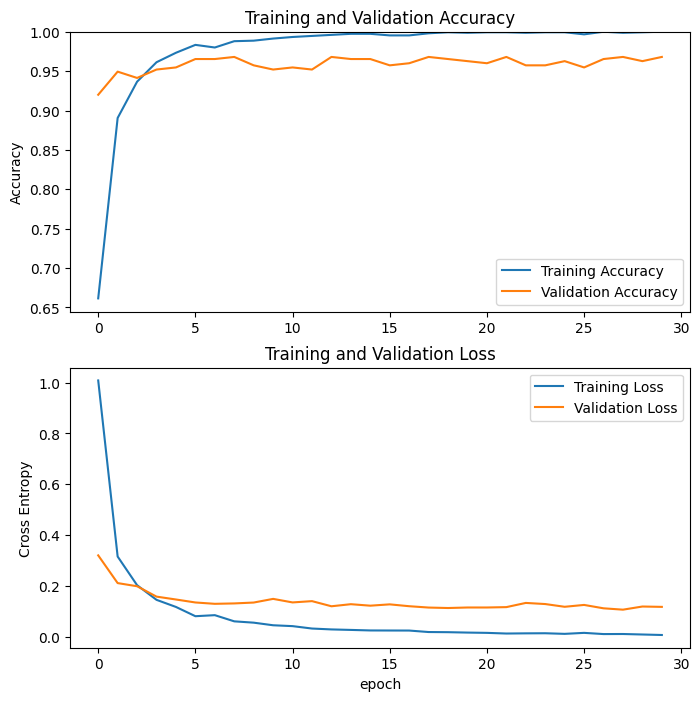

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Model Evaluation

In [15]:
model.evaluate(x=[X_test_R,X_test_V],y=y_test_tensor,batch_size=BATCH_SIZE)

16/16 [==============================] - 145s 9s/step - loss: 0.1074 - accuracy: 0.9776


[0.10738936066627502, 0.977642297744751]

16/16 [==============================] - 134s 8s/step


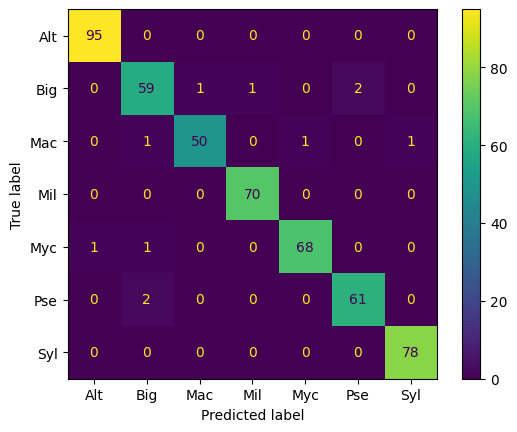

Accuracy : 0.9776422764227642
Balanced Accuracy : 0.9742266718007958


In [16]:
y_pred=np.argmax(model.predict(x=[X_test_R,X_test_V]),axis=-1)
y_obs=y_test_tensor
# let's use sklearn
lb=["Alt","Big","Mac","Mil","Myc","Pse","Syl"]
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score
le = preprocessing.LabelEncoder()
le.fit(lb)
y_pred=le.inverse_transform(y_pred)
y_obs=le.inverse_transform(y_obs)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_obs,
y_pred,labels=lb),display_labels=lb)
disp.plot()
plt.show()
print("Accuracy : "+str(accuracy_score(y_obs, y_pred)))
print("Balanced Accuracy : "+str(balanced_accuracy_score(y_obs, y_pred)))

### Modèle multi-vue avec couche FC before softmax

In [13]:
inputs1 = tf.keras.Input(shape=(224, 224, 3))
x1 = preprocess_input(inputs1)
x1 = base_model(x1, training=False)
x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)
x1 = tf.keras.layers.Dropout(0.2)(x1)
inputs2 = tf.keras.Input(shape=(224, 224, 3))
x2 = preprocess_input2(inputs2) # x2 = preprocess_input(inputs2)
x2 = base_model2(x2, training=False) # x2 = base_model(x2, training=False)
x2 = tf.keras.layers.GlobalAveragePooling2D()(x2)
x2 = tf.keras.layers.Dropout(0.2)(x2)
fuz = tf.keras.layers.Concatenate()([x1, x2])
x = tf.keras.layers.Dense(1024,activation='relu')
x = tf.keras.layers.Dense(CLASSES, activation = 'softmax')(fuz)
outputs = x
model_with_fc = tf.keras.Model(inputs=[inputs1,inputs2], outputs=outputs)

In [14]:
base_learning_rate = 10**(-3)
model_with_fc.compile(optimizer=tf.keras.optimizers.
Adam(learning_rate=base_learning_rate),
loss="sparse_categorical_crossentropy",
metrics=['accuracy'])

In [16]:
base_path = "/home/onyxia/work/pfe-deep-learning-maladies-plantes"

In [18]:
path_to_save = os.path.join(base_path,"save_models/multi_view/",f'ECHANT_recto_EfficientNetB5_verso_VGG16_weight_imagenet_one_fc_layer_batch_size_{BATCH_SIZE}.h5')

In [19]:
initial_epochs = 30 #30
history = model_with_fc.fit([X_train_R,X_train_V],
y=y_train_tensor,
batch_size=BATCH_SIZE,
epochs=initial_epochs,
validation_split=0.2) 

model_with_fc.save_weights(path_to_save,save_format='h5')

Epoch 1/30
47/47 [==============================] - 370s 7s/step - loss: 1.1402 - accuracy: 0.6368 - val_loss: 0.3841 - val_accuracy: 0.9040
Epoch 2/30
47/47 [==============================] - 322s 7s/step - loss: 0.3132 - accuracy: 0.9032 - val_loss: 0.2419 - val_accuracy: 0.9307
Epoch 3/30
47/47 [==============================] - 319s 7s/step - loss: 0.2022 - accuracy: 0.9433 - val_loss: 0.2160 - val_accuracy: 0.9387
Epoch 4/30
47/47 [==============================] - 340s 7s/step - loss: 0.1523 - accuracy: 0.9573 - val_loss: 0.1907 - val_accuracy: 0.9413
Epoch 5/30
47/47 [==============================] - 319s 7s/step - loss: 0.1252 - accuracy: 0.9653 - val_loss: 0.1709 - val_accuracy: 0.9493
Epoch 6/30
47/47 [==============================] - 322s 7s/step - loss: 0.0923 - accuracy: 0.9773 - val_loss: 0.1600 - val_accuracy: 0.9573
Epoch 7/30
47/47 [==============================] - 321s 7s/step - loss: 0.0706 - accuracy: 0.9866 - val_loss: 0.1562 - val_accuracy: 0.9547
Epoch 8/30
47

In [21]:
from subprocess import run

run(f"mc cp {path_to_save} s3/id1693/PFE/save_models/multiview/ECHANT_recto_EfficientNetB5_verso_VGG16_weight_imagenet_one_fc_layer_batch_size_{BATCH_SIZE}.h5",shell=True)

`/home/onyxia/work/pfe-deep-learning-maladies-plantes/save_models/multi_view/ECHANT_recto_EfficientNetB5_verso_VGG16_weight_imagenet_one_fc_layer_batch_size_32.h5` -> `s3/id1693/PFE/save_models/multiview/ECHANT_recto_EfficientNetB5_verso_VGG16_weight_imagenet_one_fc_layer_batch_size_32.h5`
Total: 0 B, Transferred: 165.60 MiB, Speed: 171.25 MiB/s


CompletedProcess(args='mc cp /home/onyxia/work/pfe-deep-learning-maladies-plantes/save_models/multi_view/ECHANT_recto_EfficientNetB5_verso_VGG16_weight_imagenet_one_fc_layer_batch_size_32.h5 s3/id1693/PFE/save_models/multiview/ECHANT_recto_EfficientNetB5_verso_VGG16_weight_imagenet_one_fc_layer_batch_size_32.h5', returncode=0)

In [23]:
run(f'bash /home/onyxia/work/save_model_sspcloud.sh',shell=True)

[main aebf3d4] save new model
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 save_models/multi_view/ECHANT_recto_EfficientNetB5_verso_VGG16_weight_imagenet_one_fc_layer_batch_size_32.h5


remote: HTTP Basic: Access denied. The provided password or token is incorrect or your account has 2FA enabled and you must use a personal access token instead of a password. See https://gitlab.com/help/topics/git/troubleshooting_git#error-on-git-fetch-http-basic-access-denied
fatal: Authentication failed for 'https://gitlab.com/lpbb/pfe-deep-learning-maladies-plantes.git/'


CompletedProcess(args='bash /home/onyxia/work/save_model_sspcloud.sh', returncode=128)

In [25]:
model_with_fc.load_weights(path_to_save)

### Plot training

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Model Evaluation

16/16 [==============================] - 44s 3s/step


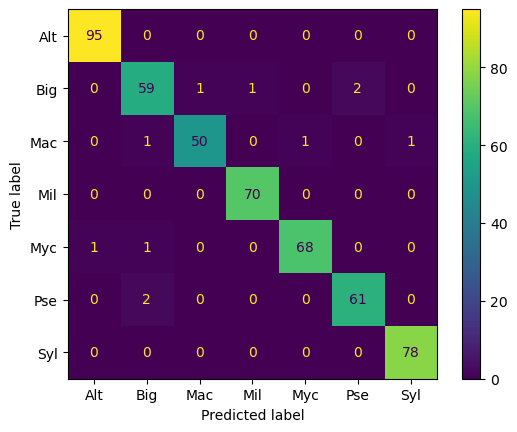

Accuracy : 0.9776422764227642
Balanced Accuracy : 0.9742266718007958


In [27]:
y_pred=np.argmax(model_with_fc.predict(x=[X_test_R,X_test_V]),axis=-1)
y_obs=y_test_tensor
# let's use sklearn
lb=["Alt","Big","Mac","Mil","Myc","Pse","Syl"]
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score
le = preprocessing.LabelEncoder()
le.fit(lb)
y_pred=le.inverse_transform(y_pred)
y_obs=le.inverse_transform(y_obs)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_obs,
y_pred,labels=lb),display_labels=lb)
disp.plot()
plt.show()
print("Accuracy : "+str(accuracy_score(y_obs, y_pred)))
print("Balanced Accuracy : "+str(balanced_accuracy_score(y_obs, y_pred)))